# Deep Learning
Minicourse, University of Liverpool <br>
April 2022 <br>
Lecturer: Mikko Pakkanen

## Example: Deep Hedging
<i>22 April 2022</i>

(exaplained later too)

The seller of the option should try to ofset:

$$PnL(\pi)=Profit/loss=price of option +trading profit/loss-(S_T-K)^{T}$$

For $(S_T-K)^{T}$ can be arbitary large so need to ofset.

Need trading profit: so do the following

$\pi_t$ number of shares hold on day $t$, $\pi_t=f_t(S_0,\dots,S_t)$

want to change strategy to change, 

hedging is the choice of $\pi$ to mitigate risk from seller.

$$trading profit/loss = \sum^{T}_{t=1} \pi_{t-1}(S_t -S_{t-1})$$

so we maximise Profit/loss. Use Deep learning to represent strategy $\pi_t$.

 $\pi_t=f_t(S_0,\dots,S_t)$ use recurrent (LSTM) here, but for easier we use  $\pi_t=f_t(S_t)$.
 
 Want to optimise $PnL(\pi)$. 
 
 With objective:minimise hedging error ${E}(PnL(\pi)^2)$ minising profit and losses (symetric quadratic function).
 or utility function ${E}(U(PnL(\pi))$ maximising $\pi$, or through risk measure.
 
 Training price paths: to get data: need to simulate. market genetarors.
 
 $\pi $ dependant on $\theta$ of network.
 
 

Let us first import the necessary libraries, and set plotting style.

In [2]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We define auxiliary functions related to the Black-Scholes model, computing call option prices and delta under the model. (random walk model of price: log prices driven by random walk with normal distrubtions). (continuous time model to mimise hedging error).

In [3]:
def BlackScholesCall(S0,r,sigma,T,K): #analtical price
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
def BlackScholesCallDelta(S0,r,sigma,T,K): #not used in trainging
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

We construct a price process $S = (S_t)_{t=0}^T$ as follows:
\begin{equation*}
S_t = S_0 \exp\bigg(\mu\frac{t}{T}+\sigma \sum_{i=1}^t \xi_i\bigg), \quad t = 0,1,\ldots,T,
\end{equation*}
where $\mu>0$, $\sigma>0$ and $S_0>0$ are constants, and $\xi_1,\ldots,\xi_T$ are mutually independent $N(0,\frac{1}{T})$-distributed random variables. This is a discrete-time version of the Black-Scholes price process. In fact, when $T \rightarrow \infty$, the process $S$ approximates the continuous-time Black-Scholes price process
\begin{equation*}
S^{\mathrm{BS}}_t = S_0 \exp(\mu t + \sigma W_t), \quad t \in [0,1],
\end{equation*}
where $W = (W_t)_{t \in [0,1]}$ is a standard Brownian motion.

Next, we set the parameter values:

In [4]:
mu = 0.1
sigma = 0.5
T = 100
S_0 = 1

We generate $N$ independent samples $S^0,\ldots,S^{N-1}$ of the price path $S = (S_t)_{t=0}^T$ and store them in an $N \times (T+1)$ array.

In [5]:
npr.seed(12345)
N = 100000
xi = npr.normal(0, np.sqrt(1 / T), (N, T))
W = np.apply_along_axis(np.cumsum, 1, xi)
W = np.concatenate((np.zeros((N, 1)), W),1)
drift = np.linspace(0, mu , T + 1)
drift = np.reshape(drift, (1, T + 1))
drift = np.repeat(drift, N, axis=0)
S = S_0 * np.exp(drift + sigma * W)

For future use in training, we compute an $N\times T$ array <code>dS</code> containing differenced prices.

In [6]:
dS = np.diff(S, 1, 1)

We also create an $N \times T \times 2$ array <code>X</code> given by
\begin{equation*}
X_{i,t,j} = \begin{cases}
\frac{t-1}{T}, & j=0, \\
S^i_{t-1}, & j = 1,
\end{cases}
\end{equation*}
for any $i=0,1,\ldots,N-1$ and $t = 0,1,\ldots,T-1$.

In [7]:
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
X = np.stack([Ti, S[:,0:T]], axis=-1)

Before proceeding further, it is useful to plot a couple of price paths in our data set.

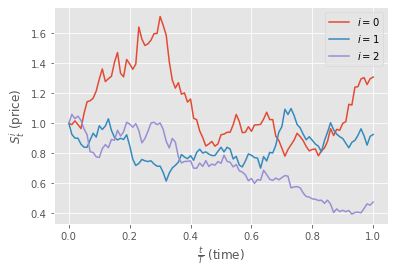

In [8]:
tim = np.linspace(0,1,T+1)
plt.plot(tim,S[0],label="$i=0$")
plt.plot(tim,S[1],label="$i=1$")         
plt.plot(tim,S[2],label="$i=2$")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$S^i_t$ (price)")
plt.legend()
plt.show()

Our aim is to hedge the call option
\begin{equation*}
(S_T - K)^+,
\end{equation*}
written on $S$,
that is, develop an adapted and self-financing trading strategy in the underlying stock so that its terminal wealth matches the option payoff as closely as possible. Such a trading strategy is specified by its initial wealth $x \in \mathbb{R}$ and position $\pi_t$ in the underlying stock at time $t$ for any $t = 0,1,\ldots,T-1$. By adaptedness, $\pi_t$ must be a function of the past prices $S_t,S_{t-1},\ldots,S_0$ only. Assuming zero interest rate, by the self-financing property, the terminal wealth of the strategy can be expressed as
\begin{equation*}
V_T = x + \sum_{t=1}^T \pi_{t-1} (S_t-S_{t-1}).
\end{equation*}
Then the option hedger's profit and loss is
\begin{equation*}
\mathrm{PnL} = V_T - (S_T - K)^+,
\end{equation*}
Note that, with $x$ and $S_0$ fixed, we can view $\mathrm{PnL}$ as a function of the trading strategy $\pi_{0},\pi_1,\ldots,\pi_{T-1}$ and the price increments $S_1-S_0,S_2-S_1,\ldots,S_T-S_{T-1}$, since
\begin{equation*}
\mathrm{PnL}(\pi_{0},\pi_1,\ldots,\pi_{T-1},;S_1-S_0,S_2-S_1,\ldots,S_T-S_{T-1}) = x + \sum_{t=1}^T \pi_{t-1} (S_t-S_{t-1}) - \bigg(S_0 + \sum_{t=1}^T (S_t-S_{t-1}) -K \bigg)^+.
\end{equation*}

The key insight of <b>deep hedging</b> is to represent the trading strategy as a neural network, whose inputs are the available market data and output is the hedging position, that is
\begin{equation*}
\pi_t = f_t(S_{t},S_{t-1},\ldots,S_0),
\end{equation*}
where $f_t$ is a neural network for any $t = 0,1,\ldots,T-1$. Here, since we know that $S$ is a Markov process, we can simplify the problem slightly (although this is not necessary in general) by seeking a single network $f : [0,1]\times \mathbb{R} \rightarrow \mathbb{R}$ such that
\begin{equation*}
\pi_t = f\bigg(\frac{t}{T},S_t\bigg), \quad t = 0,1,\ldots,T-1.
\end{equation*}
For $f$, we specify
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{Sigmoid}),
\end{equation*}
where we choose $\mathrm{Sigmoid}$ as the output activation function due to the financial intuition that the hedging position should be between $0$ and $1$. (This choice helps training, but is not really necessary.)

To evaluate $\mathrm{PnL}$ for each sample $i = 0,1,\ldots,N-1$, we need all values $f(0,S^i_0),f(\frac{1}{T},S^i_1),\ldots,f(\frac{T-1}{T},S^i_{T-1})$. To this end, we specify in <b>Keras</b> a network whose input shape is <code>(None, T, 2)</code>. Then <b>Keras</b> effectively creates a two-input network that is applied to the feature array <code>X</code>, so that for each $i = 0,1,\ldots,N-1$, 
$$
f(\boldsymbol{X}_{i,0,0:1}),f(\boldsymbol{X}_{i,1,0:1}),\ldots,f(\boldsymbol{X}_{i,T-1,0:1})
$$
are computed, as required. In other words, <b>Keras</b> automatically applies the same network at every time point in the time series. The output shape is then <code>(None, T, 1)</code>; per sample we get a time series with <code>T</code> values.

In [9]:
f = keras.Sequential([
    keras.layers.InputLayer(input_shape=(T, 2)),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
f.summary()
keras.utils.plot_model(f, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 100)          300       
                                                                 
 dense_1 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_3 (Dense)             (None, 100, 1)            101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


We train the network so that quadratic hedging error, that is, $\mathrm{PnL}^2$ is empirically minimised. To this end, we define loss function
\begin{equation*}
\ell\big((\hat{y}_0,\hat{y}_1,\ldots,\hat{y}_{T-1}),(y_0,y_1,\ldots,y_{T-1})\big) := \mathrm{PnL}(\hat{y}_0,\hat{y}_1,\ldots,\hat{y}_{T-1};y_0,y_1,\ldots,y_{T-1})^2.
\end{equation*}
We fix $x$ as the corresponding Black-Scholes call price $\mathrm{BS}(S_0,K,1)$. The loss function $\ell$ is a custom one, so it needs to be implemented separately. When implementing it, it is important that we use functions from the <i>backend</i> of <b>Keras</b> imported here as <code>kb</code>; they are functions that <b>TensorFlow</b> is able to differentiate algorithmically. 

In [10]:
K = 1
callprice = BlackScholesCall(S_0, 0, sigma, 1, K)
def loss_call(y_true,y_pred):
    return (callprice + kb.sum(y_pred * y_true, axis=-1) - kb.maximum(S_0 + kb.sum(y_true, axis=-1) - K,0.))**2

We train now the network using Adam optimisation algorithm, minibatch size $100$, doing $4$ epochs. In training, the features are provided via the array <code>X</code> constructed above while the $y$-values are given by the array <code>dS</code>, so that
\begin{equation*}
\hat{y}_t = f\Big(\frac{t}{T},S^i_t\Big), \quad y_t = S^i_{t+1} - S^i_{t}, \quad t=0,1,\ldots,T-1,
\end{equation*}
as required.

In [11]:
epochs = 4
f.compile(optimizer='adam', loss=loss_call)
f.fit(X, dS, batch_size=100, epochs=epochs)

Epoch 1/4
1000/1000 [==============================] - 18s 17ms/step - loss: 0.0017
Epoch 2/4
1000/1000 [==============================] - 16s 16ms/step - loss: 3.5182e-04
Epoch 3/4
1000/1000 [==============================] - 16s 16ms/step - loss: 3.3497e-04
Epoch 4/4
1000/1000 [==============================] - 16s 16ms/step - loss: 3.2825e-04


Since for large $T$ the price process $S$ (under time rescaling) is close to the Black-Scholes price process $S^{\mathrm{BS}}$, the hedging strategy $\pi_t = f(\frac{t}{T},S_t)$ should be close to the (continuous-time) Black-Scholes delta hedging strategy
\begin{equation*}
\pi^\mathrm{BS}_t = \frac{\partial}{\partial S}\mathrm{BS}\bigg(S_t,K,1-\frac{t}{T}\bigg),
\end{equation*}
which amounts to perfect replication, $\mathrm{PnL}=0$, in continuous time.

Let us study how close the deep hedging strategy is to Black-Scholes. We first look at the hedge as a function of the current price of the underlying.

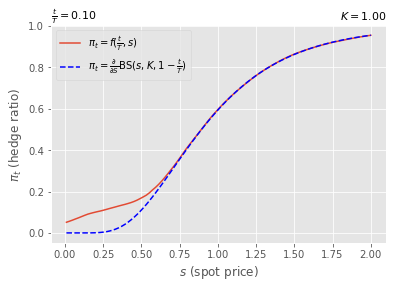

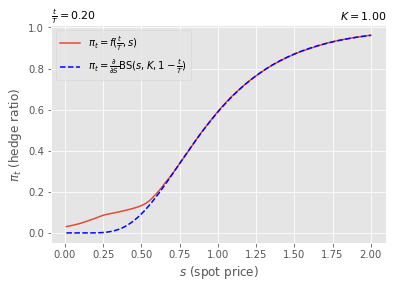

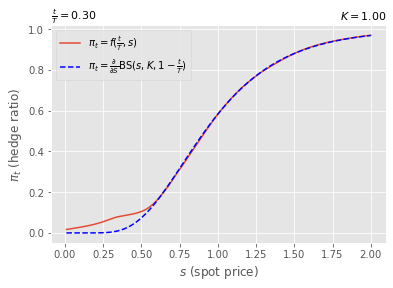

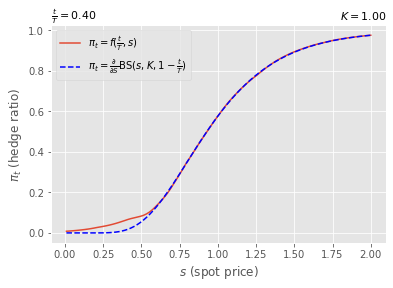

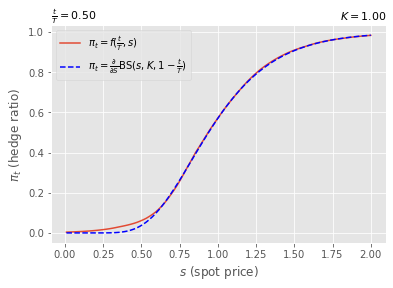

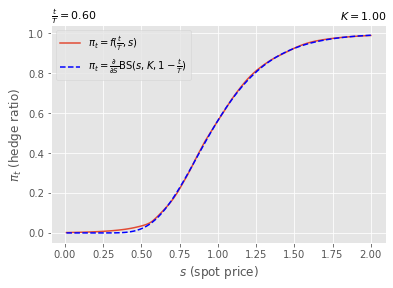

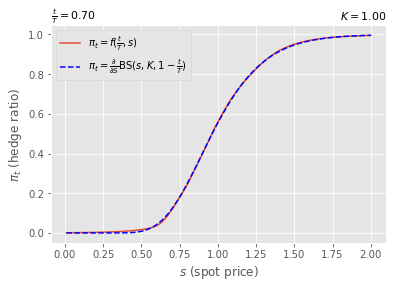

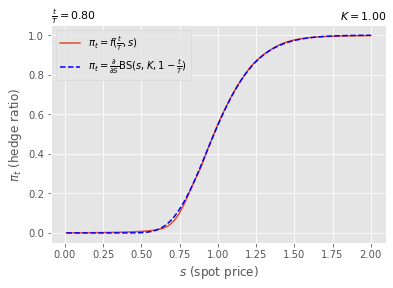

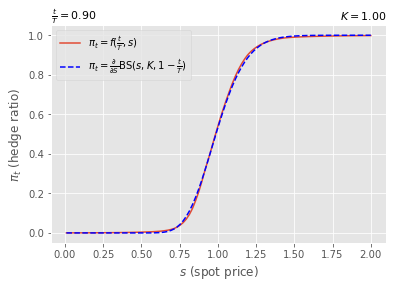

In [12]:
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    Delta_learn = np.reshape(f.predict(Xpr), (100,))
    Delta_BS = BlackScholesCallDelta(Spr, 0, sigma, 1-t, K)
    plt.plot(Spr, Delta_learn, label=r"$\pi_t=f(\frac{t}{T},s)$")
    plt.plot(Spr, Delta_BS, "b--", label=r"$\pi_t=\frac{\partial}{\partial S}\mathrm{BS}(s,K,1-\frac{t}{T})$")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\pi_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'$K=$%1.2f' % K, loc='right', fontsize=11)
    plt.legend()
    plt.show()

 why discrepancy? not sampled well, not many price paths to explore this area
 
 looking at deep hedge vs black sholes hedging straat.

The deep hedge and the Black-Scholes delta hedge are in good agreement, apart from the region where $t$ and $s$ are small (which is due to the fact that we do not have many training samples in this region). We can also confirm that the paths of the realised hedging strategies match very well.

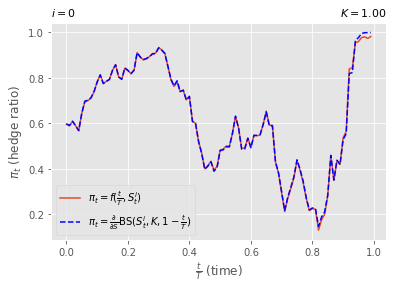

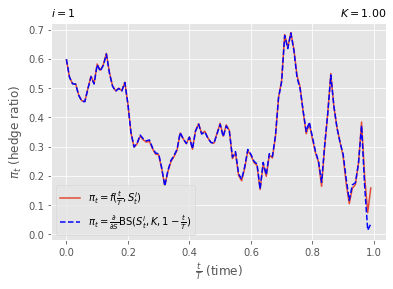

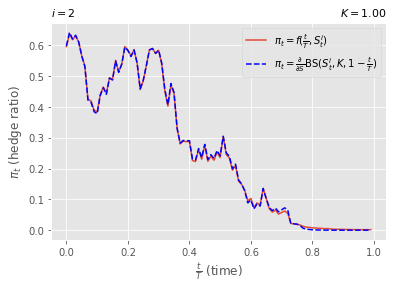

In [13]:
for i in [0, 1, 2]:
    Delta_BS = BlackScholesCallDelta(X[i,:,1], 0, sigma, 1-X[i,:,0], K)
    Delta_learn = np.reshape(f.predict(X[i:(i+1),:,:]), (T, ))
    plt.plot(X[i,:,0], Delta_learn, label=r"$\pi_t=f(\frac{t}{T},S^i_t)$")
    plt.plot(X[i,:,0], Delta_BS, "b--", label=r"$\pi_t=\frac{\partial}{\partial S}\mathrm{BS}(S^i_t,K,1-\frac{t}{T})$")
    plt.xlabel(r"$\frac{t}{T}$ (time)")
    plt.ylabel(r"$\pi_t$ (hedge ratio)")
    plt.title(r'$i=$%1.0f' % i, loc='left', fontsize=11)
    plt.title(r'$K=$%1.2f' % K, loc='right', fontsize=11)
    plt.legend()
    plt.show()

In effect, we have numerically solved the Black-Scholes delta hedge by deep learning! Note that this is <b>unsupervised learning</b>: we did not tell the network $f$ what the Black-Scholes delta hedge is, it learned it by PnL optimisation.